### Reacher-v2 Environment

In [1]:
import gym
import time
import random

In [2]:
env = gym.make("Reacher-v2")
state = env.reset()


Creating offscreen glfw


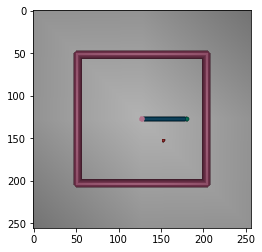

In [12]:
data = env.render(mode='rgb_array', width=256, height=256)
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(data)
plt.show()

In [3]:
env.observation_space


Box(11,)

In [4]:
env.action_space
# [random.choice(env.action_space) for _ in range(10)]

[[-0.1, 0],
 [-0.01, 0],
 [-0.005, 0],
 [0.005, 0],
 [0.01, 0],
 [0.1, 0],
 [0, -0.1],
 [0, -0.01],
 [0, -0.005],
 [0, 0.005],
 [0, 0.01],
 [0, 0.1]]

In [5]:
env.action_space = [[0.1, 0]]
env.action_space

[[0.1, 0]]

In [6]:
env.reset()
env.action_space

[[0.1, 0]]

In [7]:
import time
step = 0
for _ in range(10):
    step += 1
    print("Step: ", step)
#     action = random.choice(env.action_space)
    action = env.action_space[0]
    print("Action: ", action)
    env.step(action)
    time.sleep(0.2)
    env.render()
env.close()

Step:  1
Action:  [0.1, 0]
Creating window glfw
Step:  2
Action:  [0.1, 0]
Step:  3
Action:  [0.1, 0]
Step:  4
Action:  [0.1, 0]
Step:  5
Action:  [0.1, 0]
Step:  6
Action:  [0.1, 0]
Step:  7
Action:  [0.1, 0]
Step:  8
Action:  [0.1, 0]
Step:  9
Action:  [0.1, 0]
Step:  10
Action:  [0.1, 0]


### Render images

In [5]:
images = []
for _ in range(10):
    data = env.render(mode='rgb_array', width=256, height=256)
    images.append(data)
#     action = env.action_space.sample()
#     actions = [[0.1, 0], [0,0.1]]
#     action = random.choice(actions)
    action = random.choice(env.action_space)
#     print("Action: ", action)
    env.step(action)
env.close()
print(data.shape)

Creating offscreen glfw
In def step....... True
In def step....... True
In def step....... True
In def step....... True
(256, 256, 3)


In [7]:
len(images)

10

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


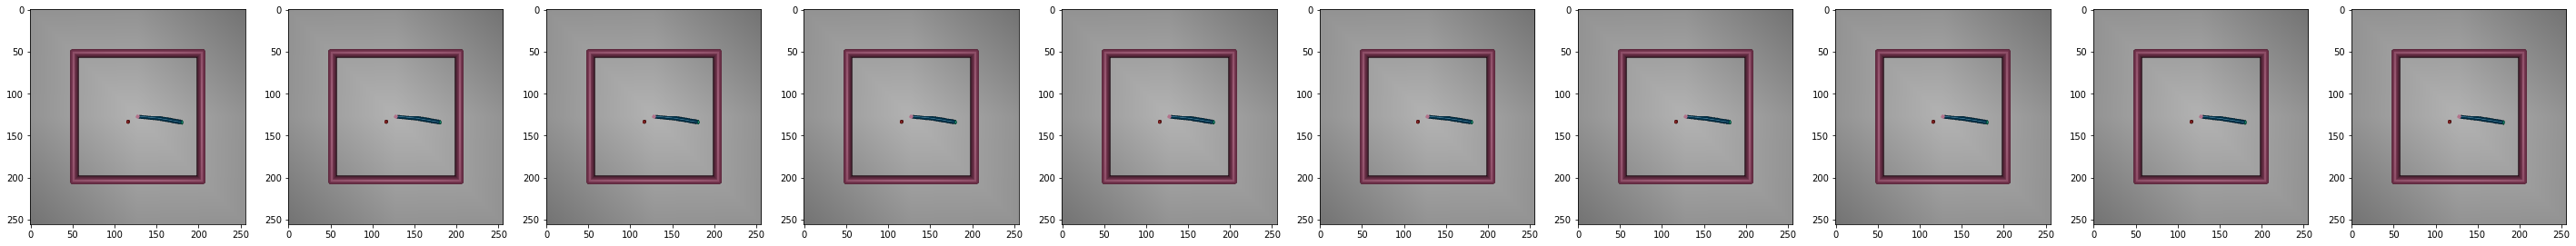

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (50,50))
for i in range(len(images)):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(images[i])
    print(images[i].shape)
plt.show()
 
# plt.imshow(data, interpolation='nearest')

# w=10
# h=10
# fig=plt.figure(figsize=(8, 8))
# columns = 5
# rows = 2
# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()

### Densely-connected NN 

In [1]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, load_model
import os
from IPython.core.debugger import set_trace

EPISODES = 1000#Maximum number of episodes
random.seed(1)  # fix the random seed
#DQN Agent for the reacher-v2
#Q function approximation with NN, experience replay, and target network
class DQNAgent:
    #Constructor for the agent (invoked when DQN is first called in main)
    def __init__(self, state_size, action_space):
        self.check_solve = False
        self.render = False  # visualize the training process 
        self.action_space = action_space
        #Get size of state and action
        self.state_size = state_size
        self.action_size = len(action_space)
        

################################################################################
################################################################################
        #Set hyper parameters for the DQN. Do not adjust those labeled as Fixed.
        self.discount_factor = 0.95
        self.learning_rate = 0.001 #6e-6  # 0.005
        self.epsilon = 0.1 #Fixed
        self.batch_size = 32 #Fixed
        self.memory_size = 500000  # 1000
        self.train_start = 1000 #Fixed
        self.target_update_frequency = 1
################################################################################
################################################################################

        #Number of test states for Q value plots
        self.test_state_no =10000 # 10000

        #Create memory buffer using deque
        self.memory = deque(maxlen=self.memory_size)

        #Create main network and target network (using build_model defined below)
        self.model = self.build_model()
        self.target_model = self.build_model()

        #Initialize target network
        self.update_target_model()

    #Approximate Q function using Neural Network
    #State is the input and the Q Values are the output.
###############################################################################
###############################################################################
        #Edit the Neural Network model here
        #Tip: Consult https://keras.io/getting-started/sequential-model-guide/
    def build_model(self):
        model = Sequential()
        model.add(Dense(16, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(16, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        opt = Adam(lr=self.learning_rate, decay=1e-6)
        model.compile(loss='mse', optimizer=opt)
#         model.compile(loss='mse', optimizer=(lr=self.learning_rate))
        
       
        #
        # self.model = Sequential()
        # self.model.add(Dense(16, input_shape=(observation_space,), activation="relu"))
        # self.model.add(Dense(16, activation="relu"))
        # self.model.add(Dense(self.action_space, activation="linear"))
        # self.model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
###############################################################################
###############################################################################
    
    #After some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    #Get action from model using epsilon-greedy policy
    def get_action(self, state):

        if np.random.rand() <= self.epsilon:
            ##############################################################
            # try out the self-designed method
            # First train:
#             action_range = [x for x in range(self.action_size)]
#             access = np.array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])
#             action = np.random.choice(action_range, p=access/sum(access))
            # Second train:
#             q_value = self.model.predict(state)
#             ind =  np.argmax(q_value[0])
#             action = random.choice([ind - 1, ind, ind + 1])
#             if action < 0:
#                 action = 0
#             if action > self.action_size - 1:
#                 action = self.action_size - 1
            ###############################################################
            action =  random.randrange(self.action_size)
#             print("action:", action)
        else:
            q_value = self.model.predict(state)
            action =  np.argmax(q_value[0])
        return action
    def get_action_test(self, state):
        q_value = self.model.predict(state)
        action =  np.argmax(q_value[0])
        return action
        
###############################################################################
###############################################################################
    #Save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) #Add sample to the end of the list

    #Sample <s,a,r,s'> from replay memory
    def train_model(self):
        if len(self.memory) < self.train_start: #Do not train if not enough memory
            return
        batch_size = min(self.batch_size, len(self.memory)) #Train on at most as many samples as you have in memory
        mini_batch = random.sample(self.memory, batch_size) #Uniformly sample the memory buffer
        #Preallocate network and target network input matrices.
        update_input = np.zeros((batch_size, self.state_size)) #batch_size by state_size two-dimensional array (not matrix!)
        update_target = np.zeros((batch_size, self.state_size)) #Same as above, but used for the target network
        action, reward, done = [], [], [] #Empty arrays that will grow dynamically

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]#Allocate s(i) to the network input array from iteration i in the batch
            action.append(mini_batch[i][1]) #Store a(i)
            reward.append(mini_batch[i][2]) #Store r(i)
            update_target[i] = mini_batch[i][3] #Allocate s'(i) for the target network array from iteration i in the batch
            done.append(mini_batch[i][4])  #Store done(i)

        target = self.model.predict(update_input) #Generate target values for training the inner loop network using the network model
        target_val = self.target_model.predict(update_target) #Generate the target values for training the outer loop target network
        #Q Learning: get maximum Q value at s' from target network
###############################################################################
###############################################################################
        #Insert your Q-learning code here
        #Tip 1: Observe that the Q-values are stored in the variable target
        #Tip 2: What is the Q-value of the action taken at the last state of the episode?
        for i in range(self.batch_size): #For every batch
            # target[i][action[i]] = random.randint(0,1)
            ############################################################### edited by andy
#             action2ind = {(-0.0001, 0):0,(0.0001, 0):1,(0 , -0.0001):2,(0, 0.0001):3}
#             action2ind = {(-0.0001, 0):0, (-0.01, 0):1,(0.0001, 0):2, (0.01, 0):3,(0 , -0.0001):4, (0, -0.01):5,(0, 0.0001):6, (0, 0.01):7}
            
#             action_tuple = tuple(action[i])
#             action_ind = action2ind[action_tuple]
            action_ind = self.action_space.index(action[i])
            if done[i]:
                target[i][action_ind]= reward[i]
            else:
                target[i][action_ind] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))
            #################################################################
#             if done[i]:
#                 target[i][action[i]]= reward[i]
#             else:
#                 target[i][action[i]] = reward[i] + self.discount_factor * (
#                     np.amax(target_val[i]))
###############################################################################
###############################################################################

        #Train the inner loop network
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)
        return
    
    
    def save_model(self, path_to_model, path_to_target):
            self.model.save(path_to_model)
            self.target_model.save(path_to_target)
            return
        
    def restore_model(self, path_to_model, path_to_target):
            self.model = load_model(path_to_model)
            self.target_model = load_model(path_to_target)
            return
        
    #Plots the score per episode as well as the maximum q value per episode, averaged over precollected states.
    def plot_data(self, episodes, scores, max_q_mean, success_log):
        pylab.figure(0)
        pylab.plot(episodes, max_q_mean, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Average Q Value")
        pylab.savefig("qvalues_rms.png")

        pylab.figure(1)
        pylab.plot(episodes, scores, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Score")
        pylab.savefig("scores_rms.png")
        
        
        pylab.figure(2)
        pylab.plot(episodes, success_log, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Successes")
        pylab.savefig("successes_rms.png")
if __name__ == "__main__":
    
    env = gym.make('Reacher-v2') #Generate Reacher-v2 environment object from the gym library
    #Get state and action sizes from the environment
    state_size = env.observation_space.shape[0]
    action_size = len(env.action_space)
#     action_size = env.action_space.n
    #Create agent, see the DQNAgent __init__ method for details
    agent = DQNAgent(state_size, env.action_space)
    
    #load the pre-trained model
    path_to_model = 'model_adam.h5'
    path_to_target = 'target_model_adam.h5'
    if os.path.isfile(path_to_model) and os.path.isfile(path_to_target):
        print("Loading the pre-trained model......")
        agent.restore_model(path_to_model, path_to_target)
    else:
        print("Pre-trained model doesn't exist.")
    

    #Collect test states for plotting Q values using uniform random policy
    test_states = np.zeros((agent.test_state_no, state_size))
    max_q = np.zeros((EPISODES, agent.test_state_no))
    max_q_mean = np.zeros((EPISODES,1))
    done = True
    for i in range(agent.test_state_no):
        if done:
            done = False
            state = env.reset()
            state = np.reshape(state, [1, state_size])
            test_states[i] = state
        else:
            #############################
#             action = random.randrange(action_size)

            action_idx = random.randrange(action_size)
            action = env.action_space[action_idx]
            ###################################
#             if done:
#                 print("Before Done: ", done)
            next_state, reward, done, info= env.step(action)
#             if done:
#                 print("Done: ", done)
#                 print("Info: ", info)
            next_state = np.reshape(next_state, [1, state_size])
            test_states[i] = state
            state = next_state

    scores, episodes = [], [] #Create dynamically growing score and episode counters
    success_log = []
    success_count = 0
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset() #Initialize/reset the environment
        state = np.reshape(state, [1, state_size]) #Reshape state so that to a 1 by state_size two-dimensional array ie. [x_1,x_2] to [[x_1,x_2]]
        #Compute Q values for plotting
        tmp = agent.model.predict(test_states)  # tmp.shape = num of test states * num of actions
        max_q[e][:] = np.max(tmp, axis=1)
        max_q_mean[e] = np.mean(max_q[e][:])
#         print("e: ", e)
#         print("tmp: ", tmp.shape)
#         print("test_states: ", test_states.shape)
        
        count = 0 
        while not done:
            
            if agent.render:
                env.render() #Show cartpole animation

            #Get action for the current state and go one step in environment
            ###################################
#             action = agent.get_action(state)
            action_idx = agent.get_action(state)
            action = env.action_space[action_idx]
            ###################################
            next_state, reward, done, success= env.step(action)
            
            next_state = np.reshape(next_state, [1, state_size]) #Reshape next_state similarly to state

            #Save sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            #Training step
            agent.train_model()
            score += reward #Store episodic reward
            state = next_state #Propagate state

            if done:
                #At the end of very episode, update the target network
                if e % agent.target_update_frequency == 0:
                    agent.update_target_model()
                #Plot the play time for every episode
                scores.append(score)
                episodes.append(e)
                if success:
                    print("Success!")
                    success_count += 1
                success_log.append(success_count)
                
                print("episode:", e, "  score:", score," q_value:", max_q_mean[e],"  memory length:",
                      len(agent.memory))

                # if the mean of scores of last 100 episodes is bigger than 195
                # stop training
                if agent.check_solve:
                    last_hundred_q_mean = np.mean(max_q_mean[-min(100, len(max_q_mean)):])
                    if abs(last_hundred_q_mean - max_q_mean[e]) / last_hundred_q_mean  <= 0.01:
                        print("solved after", e-100, "episodes")
                        agent.save_model(path_to_model, path_to_target)
                        print("Models are saved.")
                        agent.plot_data(episodes,scores,max_q_mean[:e+1], success_log)
                        sys.exit()
    agent.plot_data(episodes,scores,max_q_mean, success_log)
    # Save the model
    agent.save_model(path_to_model, path_to_target)
    env.close()


Using TensorFlow backend.
W0626 10:34:57.061197 4413048256 deprecation_wrapper.py:119] From /Users/chingandywu/master-thesis/code/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 10:34:57.113384 4413048256 deprecation_wrapper.py:119] From /Users/chingandywu/master-thesis/code/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 10:34:57.133749 4413048256 deprecation_wrapper.py:119] From /Users/chingandywu/master-thesis/code/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Theta:  [0. 0.]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.   0.   0.1 -0.1]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 566
Trainable params: 566
Non-trainable params: 0
_________________________________________________________________


W0626 10:34:57.347746 4413048256 deprecation_wrapper.py:119] From /Users/chingandywu/master-thesis/code/.venv/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0626 10:34:57.569154 4413048256 deprecation_wrapper.py:119] From /Users/chingandywu/master-thesis/code/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0626 10:34:57.571660 4413048256 deprecation_wrapper.py:119] From /Users/chingandywu/master-thesis/code/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                192       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
Total params: 566
Trainable params: 566
Non-trainable params: 0
_________________________________________________________________
Pre-trained model doesn't exist.
Theta:  [-0.03926736 -0.050993  ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03926736 -0.050993    0.08774396  0.00350674]
Theta:  [-0.03959841 -0.05103825]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03959841 -0.05103825  0.08774396  0.00350674]
Theta:  [-0.04031703 -0.05147974]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04031703 -0.05147974  0.08774396  0.00350674]
Theta:  [-0.044

[-0.22840026 -0.20315823  0.18525621 -0.06210978]
Theta:  [-0.25007333 -0.22968982]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.25007333 -0.22968982  0.18525621 -0.06210978]
Theta:  [-0.27528561 -0.25964115]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.27528561 -0.25964115  0.18525621 -0.06210978]
Theta:  [-0.09183859  0.05198271]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09183859  0.05198271  0.09359343  0.02962942]
Theta:  [-0.09182155  0.05198905]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09182155  0.05198905  0.09359343  0.02962942]
Theta:  [0.07060416 0.00977343]
qpos:  <class 'numpy.ndarray'> (4,)
[0.07060416 0.00977343 0.14506902 0.0030955 ]
Theta:  [0.07053794 0.00972459]
qpos:  <class 'numpy.ndarray'> (4,)
[0.07053794 0.00972459 0.14506902 0.0030955 ]
Theta:  [0.07047319 0.00927945]
qpos:  <class 'numpy.ndarray'> (4,)
[0.07047319 0.00927945 0.14506902 0.0030955 ]
Theta:  [0.07041002 0.0080512 ]
qpos:  <class 'numpy.ndarray'> (4,)
[0.07041002 0.0080512  0.14506902 0.0030955 ]
Theta:  [0.070

[-0.95890101 -0.34030821  0.09896934 -0.14755656]
Theta:  [-0.08821038  0.06238183]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08821038  0.06238183  0.01148854 -0.17494924]
Theta:  [-0.08822951  0.06243684]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08822951  0.06243684  0.01148854 -0.17494924]
Theta:  [0.01135651 0.03021752]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01135651  0.03021752  0.0784187  -0.15185878]
Theta:  [0.01130453 0.02984294]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01130453  0.02984294  0.0784187  -0.15185878]
Theta:  [0.01085682 0.0290813 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01085682  0.0290813   0.0784187  -0.15185878]
Theta:  [0.01002369 0.02833488]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01002369  0.02833488  0.0784187  -0.15185878]
Theta:  [0.00920704 0.02760324]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00920704  0.02760324  0.0784187  -0.15185878]
Theta:  [0.00840653 0.02688607]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00840653  0.02688607  0.0784187  -0.15185878]
Th

Theta:  [0.08114049 0.06553301]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.08114049  0.06553301  0.15960281 -0.05066821]
Theta:  [0.07965378 0.06088117]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07965378  0.06088117  0.15960281 -0.05066821]
Theta:  [0.07780107 0.05237518]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07780107  0.05237518  0.15960281 -0.05066821]
Theta:  [0.07559067 0.04403773]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07559067  0.04403773  0.15960281 -0.05066821]
Theta:  [0.07342393 0.03586532]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07342393  0.03586532  0.15960281 -0.05066821]
Theta:  [0.06733093 0.02785624]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.06733093  0.02785624  0.15960281 -0.05066821]
Theta:  [0.05741722 0.01603441]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05741722  0.01603441  0.15960281 -0.05066821]
Theta:  [0.04770119 0.00010289]
qpos:  <class 'numpy.ndarray'> (4,)
[ 4.77011884e-02  1.02888769e-04  1.59602813e-01 -5.06682071e-02]
Theta:  [ 0.03817736 -0.01590794]
qpos: 

[-0.29229676 -0.36822172  0.06514869 -0.04416044]
Theta:  [-0.31894387 -0.40519611]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.31894387 -0.40519611  0.06514869 -0.04416044]
Theta:  [-0.34903223 -0.44538353]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.34903223 -0.44538353  0.06514869 -0.04416044]
Theta:  [-0.38643821 -0.48477254]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.38643821 -0.48477254  0.06514869 -0.04416044]
Theta:  [-0.42704793 -0.5233804 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.42704793 -0.5233804   0.06514869 -0.04416044]
Theta:  [-0.466855   -0.56162129]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.466855   -0.56162129  0.06514869 -0.04416044]
Theta:  [-0.50587391 -0.60347262]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.50587391 -0.60347262  0.06514869 -0.04416044]
Theta:  [-0.54808995 -0.64844046]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.54808995 -0.64844046  0.06514869 -0.04416044]
Theta:  [-0.00080993 -0.00630859]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00080993 -0.00630859 -0.02369041  0.

[-0.09195233  0.09134191 -0.09551206  0.07039182]
Theta:  [-0.09314121  0.09129213]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09314121  0.09129213 -0.09551206  0.07039182]
Theta:  [-0.0947007   0.09084619]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0947007   0.09084619 -0.09551206  0.07039182]
Theta:  [-0.09622918  0.09001443]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09622918  0.09001443 -0.09551206  0.07039182]
Theta:  [-0.0826311   0.07460716]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0826311   0.07460716 -0.03909552  0.0407123 ]
Theta:  [-0.08662821  0.07466747]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08662821  0.07466747 -0.03909552  0.0407123 ]
Theta:  [-0.09448896  0.07472808]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09448896  0.07472808 -0.03909552  0.0407123 ]
Theta:  [-0.10219407  0.07439015]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10219407  0.07439015 -0.03909552  0.0407123 ]
Theta:  [-0.10974664  0.07366421]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10974664  0.07366421 -0.03909552  0.

[-0.72562713 -1.35764705 -0.09117389 -0.1097717 ]
Theta:  [-0.75091373 -1.39193843]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.75091373 -1.39193843 -0.09117389 -0.1097717 ]
Theta:  [-0.77570074 -1.42555089]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.77570074 -1.42555089 -0.09117389 -0.1097717 ]
Theta:  [-0.79999794 -1.45889514]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.79999794 -1.45889514 -0.09117389 -0.1097717 ]
Theta:  [-0.82381501 -1.49197385]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.82381501 -1.49197385 -0.09117389 -0.1097717 ]
Theta:  [-0.84755856 -1.52439756]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.84755856 -1.52439756 -0.09117389 -0.1097717 ]
Theta:  [-0.87122738 -1.55617924]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.87122738 -1.55617924 -0.09117389 -0.1097717 ]
Theta:  [-0.89442849 -1.58733167]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.89442849 -1.58733167 -0.09117389 -0.1097717 ]
Theta:  [-0.91717111 -1.61786731]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.91717111 -1.61786731 -0.09117389 -0.

Theta:  [-1.13932524 -0.37688215]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.13932524 -0.37688215 -0.00167064 -0.04159895]
Theta:  [-1.18332014 -0.4063352 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.18332014 -0.4063352  -0.00167064 -0.04159895]
Theta:  [-1.22644517 -0.43560259]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.22644517 -0.43560259 -0.00167064 -0.04159895]
Theta:  [-1.26871611 -0.46865811]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.26871611 -0.46865811 -0.00167064 -0.04159895]
Theta:  [-1.31015014 -0.50500572]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.31015014 -0.50500572 -0.00167064 -0.04159895]
Theta:  [-1.35076529 -0.54063384]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.35076529 -0.54063384 -0.00167064 -0.04159895]
Theta:  [-1.39057775 -0.57555671]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.39057775 -0.57555671 -0.00167064 -0.04159895]
Theta:  [-1.42960325 -0.61018555]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.42960325 -0.61018555 -0.00167064 -0.04159895]
Theta:  [-1.46785602 -0.64849631]
qpos: 

Theta:  [-0.07736293  0.07272744]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07736293  0.07272744  0.11536706  0.04992918]
Theta:  [-0.07735119  0.07235475]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07735119  0.07235475  0.11536706  0.04992918]
Theta:  [-0.05208881 -0.07042444]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05208881 -0.07042444  0.03874852 -0.0245201 ]
Theta:  [-0.05212716 -0.07046718]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05212716 -0.07046718  0.03874852 -0.0245201 ]
Theta:  [0.04893654 0.07431433]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04893654  0.07431433  0.08468649 -0.10148036]
Theta:  [0.0485277 0.0743296]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.0485277   0.0743296   0.08468649 -0.10148036]
Theta:  [-0.01041705  0.01646837]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.01041705  0.01646837  0.01704244  0.08178609]
Theta:  [-0.01048588  0.01244283]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.01048588  0.01244283  0.01704244  0.08178609]
Theta:  [-0.07253758  0.01901984]
qpos:  <clas

Theta:  [0.05281939 0.05836626]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05281939  0.05836626 -0.04453095 -0.15871196]
Theta:  [0.0528442 0.0580318]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.0528442   0.0580318  -0.04453095 -0.15871196]
Theta:  [0.05287021 0.05333654]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05287021  0.05333654 -0.04453095 -0.15871196]
Theta:  [0.05289734 0.04439056]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05289734  0.04439056 -0.04453095 -0.15871196]
Theta:  [0.05292403 0.03522706]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05292403  0.03522706 -0.04453095 -0.15871196]
Theta:  [0.05255321 0.02624512]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05255321  0.02624512 -0.04453095 -0.15871196]
Theta:  [0.05179554 0.01704389]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05179554  0.01704389 -0.04453095 -0.15871196]
Theta:  [0.05105294 0.00763017]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05105294  0.00763017 -0.04453095 -0.15871196]
Theta:  [ 0.05032649 -0.00556996]
qpos:  <class 'numpy.nda

Theta:  [-0.09008667  0.07509375]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09008667  0.07509375 -0.07101599 -0.01337815]
Theta:  [-0.10591525  0.06728289]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10591525  0.06728289 -0.07101599 -0.01337815]
Theta:  [-0.1218277   0.05962669]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.1218277   0.05962669 -0.07101599 -0.01337815]
Theta:  [-0.13781975  0.0521221 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.13781975  0.0521221  -0.07101599 -0.01337815]
Theta:  [-0.15349553  0.04476596]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.15349553  0.04476596 -0.07101599 -0.01337815]
Theta:  [-0.16886131  0.03755533]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.16886131  0.03755533 -0.07101599 -0.01337815]
Theta:  [-0.18432012  0.03048749]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.18432012  0.03048749 -0.07101599 -0.01337815]
Theta:  [-0.1998675   0.02355962]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.1998675   0.02355962 -0.07101599 -0.01337815]
Theta:  [-0.21510586  0.01279599]
qpos: 

Theta:  [ 0.09155534 -0.07247492]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.09155534 -0.07247492  0.06560791 -0.12196164]
Theta:  [ 0.09163895 -0.07240446]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.09163895 -0.07240446  0.06560791 -0.12196164]
Theta:  [-0.04378173  0.04913905]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04378173  0.04913905  0.05229353 -0.08571378]
Theta:  [-0.04377909  0.04522349]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04377909  0.04522349  0.05229353 -0.08571378]
Theta:  [-0.04774406  0.0374406 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04774406  0.0374406   0.05229353 -0.08571378]
Theta:  [-0.05557338  0.02981329]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05557338  0.02981329  0.05229353 -0.08571378]
Theta:  [-0.06324773  0.02193964]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06324773  0.02193964  0.05229353 -0.08571378]
Theta:  [-0.0707702   0.01382718]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0707702   0.01382718  0.05229353 -0.08571378]
Theta:  [-0.082113    0.00587682]
qpos: 

Theta:  [-1.26969926 -1.2579101 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.26969926 -1.2579101   0.00780202 -0.00373738]
Theta:  [-1.31746602 -1.3042476 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.31746602 -1.3042476   0.00780202 -0.00373738]
Theta:  [-1.36428914 -1.35006473]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.36428914 -1.35006473  0.00780202 -0.00373738]
Theta:  [-1.41018727 -1.39536917]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.41018727 -1.39536917  0.00780202 -0.00373738]
Theta:  [-1.45517871 -1.43977642]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.45517871 -1.43977642  0.00780202 -0.00373738]
Theta:  [-1.49928135 -1.48330426]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.49928135 -1.48330426  0.00780202 -0.00373738]
Theta:  [-1.5425127  -1.52597008]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.5425127  -1.52597008  0.00780202 -0.00373738]
Theta:  [-1.58488993 -1.56779097]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.58488993 -1.56779097  0.00780202 -0.00373738]
Theta:  [-1.62642924 -1.61275644]
qpos: 

[-0.06379187  0.09453445  0.07546661 -0.01099575]
Theta:  [-0.06463007  0.0945988 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06463007  0.0945988   0.07546661 -0.01099575]
Theta:  [-0.06545169  0.09466188]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06545169  0.09466188  0.07546661 -0.01099575]
Theta:  [-0.07022611  0.09472524]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07022611  0.09472524  0.07546661 -0.01099575]
Theta:  [-0.07884727  0.09081605]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07884727  0.09081605  0.07546661 -0.01099575]
Theta:  [-0.08729642  0.08303779]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08729642  0.08303779  0.07546661 -0.01099575]
Theta:  [-0.0955785   0.07541345]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0955785   0.07541345  0.07546661 -0.01099575]
Theta:  [-0.10369667  0.06754273]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10369667  0.06754273  0.07546661 -0.01099575]
Theta:  [-0.11562323  0.05943466]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.11562323  0.05943466  0.07546661 -0.

Theta:  [-0.19644253 -0.17612609]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.19644253 -0.17612609  0.02760135 -0.08743581]
Theta:  [-0.21377211 -0.20610218]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.21377211 -0.20610218  0.02760135 -0.08743581]
Theta:  [-0.23470183 -0.23588069]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.23470183 -0.23588069  0.02760135 -0.08743581]
Theta:  [-0.25521624 -0.2694372 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.25521624 -0.2694372   0.02760135 -0.08743581]
Theta:  [-0.27929291 -0.30627437]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.27929291 -0.30627437  0.02760135 -0.08743581]
Theta:  [-0.30723354 -0.34238073]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.30723354 -0.34238073  0.02760135 -0.08743581]
Theta:  [-0.33501482 -0.38174506]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.33501482 -0.38174506  0.02760135 -0.08743581]
Theta:  [-0.36224558 -0.42467386]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.36224558 -0.42467386  0.02760135 -0.08743581]
Theta:  [-0.38893825 -0.46714753]
qpos: 

Theta:  [-0.08632723 -0.00785959]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08632723 -0.00785959  0.17100794 -0.07300173]
Theta:  [-0.09036103 -0.00782259]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09036103 -0.00782259  0.17100794 -0.07300173]
Theta:  [-0.09825776 -0.00778483]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09825776 -0.00778483  0.17100794 -0.07300173]
Theta:  [-0.10599814 -0.00814515]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10599814 -0.00814515  0.17100794 -0.07300173]
Theta:  [-0.11358526 -0.00889304]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.11358526 -0.00889304  0.17100794 -0.07300173]
Theta:  [-0.12499138 -0.00962464]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.12499138 -0.00962464  0.17100794 -0.07300173]
Theta:  [-0.14011445 -0.01073759]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.14011445 -0.01073759  0.17100794 -0.07300173]
Theta:  [-0.15533515 -0.01222311]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.15533515 -0.01222311  0.17100794 -0.07300173]
Theta:  [-0.17064908 -0.01367919]
qpos: 

[-0.21087304 -0.26009928  0.01688259 -0.121098  ]
Theta:  [-0.22818702 -0.28881013]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.22818702 -0.28881013  0.01688259 -0.121098  ]
Theta:  [-0.24515886 -0.31695267]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.24515886 -0.31695267  0.01688259 -0.121098  ]
Theta:  [-0.26179532 -0.34453816]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.26179532 -0.34453816  0.01688259 -0.121098  ]
Theta:  [-0.27810304 -0.37157761]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.27810304 -0.37157761  0.01688259 -0.121098  ]
Theta:  [-0.29408837 -0.39847912]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.29408837 -0.39847912  0.01688259 -0.121098  ]
Theta:  [-0.31372689 -0.42524129]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.31372689 -0.42524129  0.01688259 -0.121098  ]
Theta:  [-0.33692003 -0.45186955]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.33692003 -0.45186955  0.01688259 -0.121098  ]
Theta:  [-0.36362387 -0.47836392]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.36362387 -0.47836392  0.01688259 -0.

Theta:  [-1.71741206 -2.1868017 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.71741206e+00 -2.18680170e+00  1.13677443e-03 -4.00912632e-02]
Theta:  [-1.7725981  -2.26577261]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.77259810e+00 -2.26577261e+00  1.13677443e-03 -4.00912632e-02]
Theta:  [-1.82669428 -2.347126  ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.82669428e+00 -2.34712600e+00  1.13677443e-03 -4.00912632e-02]
Theta:  [-1.87972205 -2.4272656 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.87972205e+00 -2.42726560e+00  1.13677443e-03 -4.00912632e-02]
Theta:  [-1.93170225 -2.50621287]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.93170225e+00 -2.50621287e+00  1.13677443e-03 -4.00912632e-02]
Theta:  [-1.98305255 -2.5835968 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.98305255e+00 -2.58359680e+00  1.13677443e-03 -4.00912632e-02]
Theta:  [-2.03417973 -2.65944838]
qpos:  <class 'numpy.ndarray'> (4,)
[-2.03417973e+00 -2.65944838e+00  1.13677443e-03 -4.00912632e-02]
Theta:  [-2.08469072 -2.73419526]
qpos:  <class 

Theta:  [ 0.00900829 -0.00043078]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00900829 -0.00043078  0.17404892 -0.00668038]
Theta:  [ 0.00055286 -0.00119609]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00055286 -0.00119609  0.17404892 -0.00668038]
Theta:  [-0.00773533 -0.00194632]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00773533 -0.00194632  0.17404892 -0.00668038]
Theta:  [-0.01585959 -0.00268176]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.01585959 -0.00268176  0.17404892 -0.00668038]
Theta:  [-0.02382162 -0.00737548]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02382162 -0.00737548  0.17404892 -0.00668038]
Theta:  [-0.03162468 -0.01592274]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03162468 -0.01592274  0.17404892 -0.00668038]
Theta:  [-0.03927331 -0.02469811]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03927331 -0.02469811  0.17404892 -0.00668038]
Theta:  [-0.04676902 -0.03766723]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04676902 -0.03766723  0.17404892 -0.00668038]
Theta:  [-0.05505749 -0.0917163 ]
qpos: 

qpos:  <class 'numpy.ndarray'> (4,)
[-0.79599859 -0.60337315 -0.09765257 -0.09938588]
Theta:  [-0.83610349 -0.62914009]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.83610349 -0.62914009 -0.09765257 -0.09938588]
Theta:  [-0.87975557 -0.65439543]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.87975557 -0.65439543 -0.09765257 -0.09938588]
Theta:  [-0.92293887 -0.67954796]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.92293887 -0.67954796 -0.09765257 -0.09938588]
Theta:  [-0.96526704 -0.70856998]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.96526704 -0.70856998 -0.09765257 -0.09938588]
Theta:  [-1.00675727 -0.74096386]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.00675727 -0.74096386 -0.09765257 -0.09938588]
Theta:  [-1.04742623 -0.77668921]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.04742623 -0.77668921 -0.09765257 -0.09938588]
Theta:  [-1.08729018 -0.81605095]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.08729018 -0.81605095 -0.09765257 -0.09938588]
Theta:  [-1.12636627 -0.85542534]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.

Theta:  [-0.07261126  0.02643186]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07261126  0.02643186  0.1523435  -0.02393687]
Theta:  [-0.08196894  0.0128013 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08196894  0.0128013   0.1523435  -0.02393687]
Theta:  [-0.0911401  -0.00450587]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0911401  -0.00450587  0.1523435  -0.02393687]
Theta:  [-0.10013    -0.02147046]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10013    -0.02147046  0.1523435  -0.02393687]
Theta:  [-0.10894221 -0.03809925]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10894221 -0.03809925  0.1523435  -0.02393687]
Theta:  [-0.1175801  -0.05479618]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.1175801  -0.05479618  0.1523435  -0.02393687]
Theta:  [-0.12604713 -0.07155724]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.12604713 -0.07155724  0.1523435  -0.02393687]
Theta:  [-0.13831587 -0.08798499]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.13831587 -0.08798499  0.1523435  -0.02393687]
Theta:  [-0.1542848  -0.10408608]
qpos: 

Theta:  [0.03583278 0.06329382]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03583278  0.06329382 -0.13207002 -0.05852851]
Theta:  [0.03576871 0.05923043]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03576871  0.05923043 -0.13207002 -0.05852851]
Theta:  [0.05659455 0.06953413]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05659455  0.06953413 -0.08495634  0.06090278]
Theta:  [0.05660491 0.0690466 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05660491  0.0690466  -0.08495634  0.06090278]
Theta:  [0.05661522 0.06817409]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05661522  0.06817409 -0.08495634  0.06090278]
Theta:  [0.05662532 0.06731885]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05662532  0.06731885 -0.08495634  0.06090278]
Theta:  [0.05663675 0.06250775]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05663675  0.06250775 -0.08495634  0.06090278]
Theta:  [-0.03912008  0.05950928]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03912008  0.05950928  0.00301735  0.17934032]
Theta:  [-0.03910877  0.05954923]
qpos:  <class 'numpy

[-0.07072953  0.02081092 -0.06957486 -0.05977267]
Theta:  [-0.08235052  0.0208439 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08235052  0.0208439  -0.06957486 -0.05977267]
Theta:  [-0.09768436  0.02087766]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09768436  0.02087766 -0.06957486 -0.05977267]
Theta:  [-0.11668395  0.02091218]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.11668395  0.02091218 -0.06957486 -0.05977267]
Theta:  [-0.13925046  0.02094739]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.13925046  0.02094739 -0.06957486 -0.05977267]
Theta:  [-0.16137045  0.02058444]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.16137045  0.02058444 -0.06957486 -0.05977267]
Theta:  [-0.18305278  0.01983388]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.18305278  0.01983388 -0.06957486 -0.05977267]
Theta:  [-0.2082753   0.01909954]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.2082753   0.01909954 -0.06957486 -0.05977267]
Theta:  [-0.23694165  0.01838108]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.23694165  0.01838108 -0.06957486 -0.

Theta:  [-0.10629693 -0.03882858]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10629693 -0.03882858 -0.04333153 -0.09432361]
Theta:  [-0.12848856 -0.04109555]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.12848856 -0.04109555 -0.04333153 -0.09432361]
Theta:  [-0.15063399 -0.04729045]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.15063399 -0.04729045 -0.04333153 -0.09432361]
Theta:  [-0.17273684 -0.0573091 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.17273684 -0.0573091  -0.04333153 -0.09432361]
Theta:  [-0.19479686 -0.06712941]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.19479686 -0.06712941 -0.04333153 -0.09432361]
Theta:  [-0.21642062 -0.07675546]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.21642062 -0.07675546 -0.04333153 -0.09432361]
Theta:  [-0.23761661 -0.08658837]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.23761661 -0.08658837 -0.04333153 -0.09432361]
Theta:  [-0.25839314 -0.09701868]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.25839314 -0.09701868 -0.04333153 -0.09432361]
Theta:  [-0.2787585  -0.10803456]
qpos: 

qpos:  <class 'numpy.ndarray'> (4,)
[-0.08360413 -0.02022816  0.1210863   0.10546137]
Theta:  [-0.09545319 -0.02851309]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09545319 -0.02851309  0.1210863   0.10546137]
Theta:  [0.08822098 0.03505282]
qpos:  <class 'numpy.ndarray'> (4,)
[0.08822098 0.03505282 0.06897423 0.11140045]
Theta:  [0.088185   0.03499237]
qpos:  <class 'numpy.ndarray'> (4,)
[0.088185   0.03499237 0.06897423 0.11140045]
Theta:  [ 0.04271365 -0.07236438]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04271365 -0.07236438  0.0150973   0.05899937]
Theta:  [ 0.04232792 -0.07243101]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04232792 -0.07243101  0.0150973   0.05899937]
Theta:  [-0.03977111 -0.06191968]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03977111 -0.06191968 -0.01568813 -0.11085887]
Theta:  [-0.03976569 -0.06193319]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03976569 -0.06193319 -0.01568813 -0.11085887]
Theta:  [ 0.09056321 -0.09016071]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.09056321 -0.

Theta:  [ 0.04169331 -0.05753886]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04169331 -0.05753886 -0.07038646 -0.01968336]
Theta:  [ 0.03357501 -0.07252542]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03357501 -0.07252542 -0.07038646 -0.01968336]
Theta:  [ 0.02522289 -0.08721518]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.02522289 -0.08721518 -0.07038646 -0.01968336]
Theta:  [ 0.01703585 -0.10161417]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01703585 -0.10161417 -0.07038646 -0.01968336]
Theta:  [ 0.00504157 -0.11572662]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00504157 -0.11572662 -0.07038646 -0.01968336]
Theta:  [-0.01462738 -0.1295567 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.01462738 -0.1295567  -0.07038646 -0.01968336]
Theta:  [-0.0378486  -0.14708437]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0378486  -0.14708437 -0.07038646 -0.01968336]
Theta:  [-0.06060765 -0.17218437]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06060765 -0.17218437 -0.07038646 -0.01968336]
Theta:  [-0.08291513 -0.20113126]
qpos: 

Theta:  [-0.13712981 -0.47433045]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.13712981 -0.47433045  0.00628519 -0.13066497]
Theta:  [-0.14847854 -0.49685348]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.14847854 -0.49685348  0.00628519 -0.13066497]
Theta:  [-0.16357233 -0.51892922]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.16357233 -0.51892922  0.00628519 -0.13066497]
Theta:  [-0.18230935 -0.54453934]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.18230935 -0.54453934  0.00628519 -0.13066497]
Theta:  [-0.20067333 -0.57756172]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.20067333 -0.57756172  0.00628519 -0.13066497]
Theta:  [-0.21867319 -0.61387679]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.21867319 -0.61387679  0.00628519 -0.13066497]
Theta:  [-0.23631756 -0.64947299]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.23631756 -0.64947299  0.00628519 -0.13066497]
Theta:  [-0.25361335 -0.68476181]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.25361335 -0.68476181  0.00628519 -0.13066497]
Theta:  [-0.27056743 -0.7197467 ]
qpos: 

Theta:  [-0.5831806  -0.96831038]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.5831806  -0.96831038  0.04273974 -0.13251372]
Theta:  [-0.61067257 -1.02281517]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.61067257 -1.02281517  0.04273974 -0.13251372]
Theta:  [-0.63762204 -1.0762409 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.63762204 -1.0762409   0.04273974 -0.13251372]
Theta:  [-0.66403959 -1.1290062 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.66403959 -1.1290062   0.04273974 -0.13251372]
Theta:  [-0.68993475 -1.18509428]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.68993475 -1.18509428  0.04273974 -0.13251372]
Theta:  [-0.71531813 -1.24401832]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.71531813 -1.24401832  0.04273974 -0.13251372]
Theta:  [-0.74020088 -1.30177578]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.74020088 -1.30177578  0.04273974 -0.13251372]
Theta:  [-0.76498987 -1.35838965]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.76498987 -1.35838965  0.04273974 -0.13251372]
Theta:  [-0.08054411 -0.05643679]
qpos: 

Theta:  [-0.18168192 -0.28130921]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.18168192 -0.28130921  0.09017836 -0.16714407]
Theta:  [-0.20059856 -0.29735716]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.20059856 -0.29735716  0.09017836 -0.16714407]
Theta:  [-0.21953812 -0.31308736]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.21953812 -0.31308736  0.09017836 -0.16714407]
Theta:  [-0.23889443 -0.32850596]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.23889443 -0.32850596  0.09017836 -0.16714407]
Theta:  [-0.25865923 -0.34361911]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.25865923 -0.34361911  0.09017836 -0.16714407]
Theta:  [-0.27842755 -0.35843303]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.27842755 -0.35843303  0.09017836 -0.16714407]
Theta:  [-0.29780353 -0.37692657]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.29780353 -0.37692657  0.09017836 -0.16714407]
Theta:  [-0.31679488 -0.39939776]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.31679488 -0.39939776  0.09017836 -0.16714407]
Theta:  [-0.33540925 -0.42579159]
qpos: 

Theta:  [-1.71456392 -3.01374483]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.71456392 -3.01374483 -0.01221405 -0.0096282 ]
Theta:  [ 0.07895585 -0.07076075]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07895585 -0.07076075  0.06247372  0.15956689]
Theta:  [ 0.07889079 -0.07068983]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07889079 -0.07068983  0.06247372  0.15956689]
Theta:  [0.0724871  0.08934697]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.0724871   0.08934697 -0.01209421 -0.18478133]
Theta:  [0.06852942 0.08931076]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.06852942  0.08931076 -0.01209421 -0.18478133]
Theta:  [-0.02812455  0.08165127]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02812455  0.08165127 -0.06921073 -0.01431389]
Theta:  [-0.02821535  0.07767579]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02821535  0.07767579 -0.06921073 -0.01431389]
Theta:  [-0.02869977  0.06983277]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02869977  0.06983277 -0.06921073 -0.01431389]
Theta:  [-0.03353798  0.06214672]
qpos:  <cl

Theta:  [0.02120863 0.05514441]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.02120863  0.05514441  0.13016196 -0.1480482 ]
Theta:  [0.02082511 0.03888626]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.02082511  0.03888626  0.13016196 -0.1480482 ]
Theta:  [0.02005479 0.02295013]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.02005479  0.02295013  0.13016196 -0.1480482 ]
Theta:  [0.01929957 0.0073295 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01929957  0.0073295   0.13016196 -0.1480482 ]
Theta:  [ 0.01856073 -0.01195466]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01856073 -0.01195466  0.13016196 -0.1480482 ]
Theta:  [ 0.01783941 -0.03877622]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01783941 -0.03877622  0.13016196 -0.1480482 ]
Theta:  [ 0.01713382 -0.06941045]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01713382 -0.06941045  0.13016196 -0.1480482 ]
Theta:  [ 0.01247304 -0.09983128]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01247304 -0.09983128  0.13016196 -0.1480482 ]
Theta:  [ 0.00396147 -0.12964836]
qpos:  <class 

Theta:  [-0.05448737 -0.28545665]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05448737 -0.28545665  0.10361941 -0.15633244]
Theta:  [-0.07241005 -0.30601518]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07241005 -0.30601518  0.10361941 -0.15633244]
Theta:  [-0.09076963 -0.32616651]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09076963 -0.32616651  0.10361941 -0.15633244]
Theta:  [-0.10916058 -0.34591885]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10916058 -0.34591885  0.10361941 -0.15633244]
Theta:  [-0.1275849  -0.36528009]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.1275849  -0.36528009  0.10361941 -0.15633244]
Theta:  [-0.14603929 -0.38425799]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.14603929 -0.38425799  0.10361941 -0.15633244]
Theta:  [-0.16412888 -0.40286027]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.16412888 -0.40286027  0.10361941 -0.15633244]
Theta:  [-0.18186073 -0.42149164]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.18186073 -0.42149164  0.10361941 -0.15633244]
Theta:  [-0.19924046 -0.44412168]
qpos: 

[-1.05714952 -0.65734968 -0.15182054 -0.0681025 ]
Theta:  [-1.12462678 -0.68868296]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.12462678 -0.68868296 -0.15182054 -0.0681025 ]
Theta:  [-1.19077004 -0.71979039]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.19077004 -0.71979039 -0.15182054 -0.0681025 ]
Theta:  [-1.2556058  -0.75028177]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.2556058  -0.75028177 -0.15182054 -0.0681025 ]
Theta:  [-1.31955686 -0.78016917]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.31955686 -0.78016917 -0.15182054 -0.0681025 ]
Theta:  [-1.38263806 -0.80946452]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.38263806 -0.80946452 -0.15182054 -0.0681025 ]
Theta:  [-1.44447227 -0.83817968]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.44447227 -0.83817968 -0.15182054 -0.0681025 ]
Theta:  [-1.50508402 -0.8667234 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.50508402 -0.8667234  -0.15182054 -0.0681025 ]
Theta:  [-1.56489444 -0.8950963 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.56489444 -0.8950963  -0.15182054 -0.

[-0.81613213 -0.49152979  0.01033186 -0.08097311]
Theta:  [-0.86046856 -0.51803165]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.86046856 -0.51803165  0.01033186 -0.08097311]
Theta:  [-0.90789766 -0.54440214]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.90789766 -0.54440214  0.01033186 -0.08097311]
Theta:  [-0.95872901 -0.57024905]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.95872901 -0.57024905  0.01033186 -0.08097311]
Theta:  [-1.00934666 -0.59558402]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.00934666 -0.59558402  0.01033186 -0.08097311]
Theta:  [-1.06332728 -0.62041591]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.06332728 -0.62041591  0.01033186 -0.08097311]
Theta:  [-1.1241531  -0.64475338]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.1241531  -0.64475338  0.01033186 -0.08097311]
Theta:  [-1.18811634 -0.66860743]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.18811634 -0.66860743  0.01033186 -0.08097311]
Theta:  [-1.25120925 -0.69198897]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.25120925 -0.69198897  0.01033186 -0.

Theta:  [-0.34269994 -0.1364768 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.34269994 -0.1364768   0.15099644 -0.09275192]
Theta:  [-0.38760651 -0.15289437]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.38760651 -0.15289437  0.15099644 -0.09275192]
Theta:  [-0.43162488 -0.16938446]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.43162488 -0.16938446  0.15099644 -0.09275192]
Theta:  [-0.4747711  -0.18991578]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.4747711  -0.18991578  0.15099644 -0.09275192]
Theta:  [-0.51706114 -0.21796004]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.51706114 -0.21796004  0.15099644 -0.09275192]
Theta:  [-0.55891048 -0.24939556]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.55891048 -0.24939556  0.15099644 -0.09275192]
Theta:  [-0.0538526  -0.02789202]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0538526  -0.02789202 -0.08495489 -0.03696476]
Theta:  [-0.05432362 -0.02794219]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05432362 -0.02794219 -0.08495489 -0.03696476]
Theta:  [-0.03109904 -0.03281571]
qpos: 

[-0.05937303 -0.12606076  0.08118909 -0.03500313]
Theta:  [-0.06857345 -0.14570284]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06857345 -0.14570284  0.08118909 -0.03500313]
Theta:  [-0.07759055 -0.16890251]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07759055 -0.16890251  0.08118909 -0.03500313]
Theta:  [-0.08642799 -0.19561573]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08642799 -0.19561573  0.08118909 -0.03500313]
Theta:  [-0.09508937 -0.22574653]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09508937 -0.22574653  0.08118909 -0.03500313]
Theta:  [-0.10357974 -0.25528087]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10357974 -0.25528087  0.08118909 -0.03500313]
Theta:  [-0.11587157 -0.28422903]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.11587157 -0.28422903  0.08118909 -0.03500313]
Theta:  [-0.13186322 -0.31299994]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.13186322 -0.31299994  0.08118909 -0.03500313]
Theta:  [-0.14753725 -0.34556878]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.14753725 -0.34556878  0.08118909 -0.

Theta:  [-0.04903411  0.06894169]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04903411  0.06894169  0.07696608 -0.0105087 ]
Theta:  [-0.04944838  0.06898981]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04944838  0.06898981  0.07696608 -0.0105087 ]
Theta:  [-0.05064562  0.06903729]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05064562  0.06903729  0.07696608 -0.0105087 ]
Theta:  [-0.05618251  0.0690855 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05618251  0.0690855   0.07696608 -0.0105087 ]
Theta:  [-0.06555105  0.06516146]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06555105  0.06516146  0.07696608 -0.0105087 ]
Theta:  [-0.07870185  0.05737018]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07870185  0.05737018  0.07696608 -0.0105087 ]
Theta:  [-0.0959322   0.04973473]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0959322   0.04973473  0.07696608 -0.0105087 ]
Theta:  [-0.11718513  0.042252  ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.11718513  0.042252    0.07696608 -0.0105087 ]
Theta:  [-0.1459295   0.03492032]
qpos: 

[-0.03505205 -0.04235274  0.13605344  0.10305877]
Theta:  [-0.03540243 -0.04228355]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03540243 -0.04228355  0.13605344  0.10305877]
Theta:  [-0.03614016 -0.04221558]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03614016 -0.04221558  0.13605344  0.10305877]
Theta:  [-0.03686314 -0.04254624]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03686314 -0.04254624  0.13605344  0.10305877]
Theta:  [ 0.03796766 -0.07021406]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03796766 -0.07021406 -0.12966173 -0.03187391]
Theta:  [ 0.03409735 -0.07026367]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03409735 -0.07026367 -0.12966173 -0.03187391]
Theta:  [ 0.08955741 -0.0091417 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.08955741 -0.0091417   0.07513158  0.07032528]
Theta:  [ 0.08947419 -0.00908034]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.08947419 -0.00908034  0.07513158  0.07032528]
Theta:  [ 0.08939262 -0.0090202 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.08939262 -0.0090202   0.07513158  0.

Theta:  [0.07487568 0.09703671]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07487568  0.09703671 -0.17804396  0.02410298]
Theta:  [0.07088069 0.096951  ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07088069  0.096951   -0.17804396  0.02410298]
Theta:  [-0.06206668  0.0837431 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06206668  0.0837431   0.01992477 -0.17029023]
Theta:  [-0.06201047  0.08364496]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06201047  0.08364496  0.01992477 -0.17029023]
Theta:  [-0.06592443  0.08355029]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06592443  0.08355029  0.01992477 -0.17029023]
Theta:  [-0.07370214  0.07948621]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07370214  0.07948621  0.01992477 -0.17029023]
Theta:  [-0.08172143  0.07155629]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08172143  0.07155629  0.01992477 -0.17029023]
Theta:  [-0.08997488  0.05981067]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08997488  0.05981067  0.01992477 -0.17029023]
Theta:  [-0.09846056  0.04435129]
qpos:  <cl

Theta:  [-0.34195757 -0.36138777]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.34195757 -0.36138777  0.02082309 -0.0607649 ]
Theta:  [-0.36436467 -0.38812824]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.36436467 -0.38812824  0.02082309 -0.0607649 ]
Theta:  [-0.3867232  -0.41433927]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.3867232  -0.41433927  0.02082309 -0.0607649 ]
Theta:  [-0.40903674 -0.44003135]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.40903674 -0.44003135  0.02082309 -0.0607649 ]
Theta:  [-0.4313021  -0.46918754]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.4313021  -0.46918754  0.02082309 -0.0607649 ]
Theta:  [-0.45312606 -0.501713  ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.45312606 -0.501713    0.02082309 -0.0607649 ]
Theta:  [-0.47451882 -0.53359463]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.47451882 -0.53359463  0.02082309 -0.0607649 ]
Theta:  [-0.4994582  -0.56484375]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.4994582  -0.56484375  0.02082309 -0.0607649 ]
Theta:  [-0.52784637 -0.59944567]
qpos: 

[-0.03810005  0.0921397   0.0529851   0.01423432]
Theta:  [-0.03810656  0.09218057]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03810656  0.09218057  0.0529851   0.01423432]
Theta:  [-0.03850985  0.09222079]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03850985  0.09222079  0.0529851   0.01423432]
Theta:  [-0.03929944  0.09226036]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03929944  0.09226036  0.0529851   0.01423432]
Theta:  [-0.0400734   0.09229914]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0400734   0.09229914  0.0529851   0.01423432]
Theta:  [-0.02988034  0.05376359]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02988034  0.05376359 -0.18758945 -0.053062  ]
Theta:  [-0.02980585  0.04973077]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02980585  0.04973077 -0.18758945 -0.053062  ]
Theta:  [0.02974873 0.00249205]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.02974873  0.00249205 -0.05832578 -0.00969209]
Theta:  [0.02940153 0.00258475]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.02940153  0.00258475 -0.05832578 -0.0096

Theta:  [-1.50997236 -1.86632474]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.50997236 -1.86632474 -0.05832578 -0.00969209]
Theta:  [-1.56337157 -1.9091916 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.56337157 -1.9091916  -0.05832578 -0.00969209]
Theta:  [-1.61966033 -1.95120886]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.61966033 -1.95120886 -0.05832578 -0.00969209]
Theta:  [-1.67880788 -1.99239336]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.67880788 -1.99239336 -0.05832578 -0.00969209]
Theta:  [-1.74073129 -2.03276152]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.74073129 -2.03276152 -0.05832578 -0.00969209]
Theta:  [-1.8014302  -2.07630261]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.8014302  -2.07630261 -0.05832578 -0.00969209]
Theta:  [-1.86490064 -2.12292718]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.86490064 -2.12292718 -0.05832578 -0.00969209]
Theta:  [-1.93145885 -2.1686277 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.93145885 -2.1686277  -0.05832578 -0.00969209]
Theta:  [-1.99709571 -2.21342271]
qpos: 

Theta:  [-0.08803306  0.06258575]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08803306  0.06258575  0.17800318  0.02946472]
Theta:  [-0.08802865  0.0625408 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08802865  0.0625408   0.17800318  0.02946472]
Theta:  [-0.08802277  0.05852396]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08802277  0.05852396  0.17800318  0.02946472]
Theta:  [-0.08801553  0.05064025]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08801553  0.05064025  0.17800318  0.02946472]
Theta:  [-0.09197753  0.04291417]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09197753  0.04291417  0.17800318  0.02946472]
Theta:  [ 0.06451991 -0.00669312]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.06451991 -0.00669312 -0.14983375 -0.02346503]
Theta:  [ 0.06459181 -0.0066855 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.06459181 -0.0066855  -0.14983375 -0.02346503]
Theta:  [-0.05249151  0.01064474]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05249151  0.01064474  0.06811735  0.06459618]
Theta:  [-0.05643688  0.01060827]
qpos: 

Theta:  [-0.08654732 -0.01312692]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08654732 -0.01312692 -0.02859127  0.1803678 ]
Theta:  [-0.08655611 -0.01303696]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08655611 -0.01303696 -0.02859127  0.1803678 ]
Theta:  [ 0.04251192 -0.07539063]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04251192 -0.07539063  0.1789989   0.02523417]
Theta:  [ 0.04252007 -0.07933379]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04252007 -0.07933379  0.1789989   0.02523417]
Theta:  [ 0.03856049 -0.08714373]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03856049 -0.08714373  0.1789989   0.02523417]
Theta:  [ 0.0267674  -0.09479602]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.0267674  -0.09479602  0.1789989   0.02523417]
Theta:  [ 0.01086788 -0.10229523]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01086788 -0.10229523  0.1789989   0.02523417]
Theta:  [-0.03642925 -0.01885598]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03642925 -0.01885598 -0.09306427 -0.07316573]
Theta:  [-0.03650843 -0.01883848]
qpos: 

Theta:  [-0.537743  -0.8567726]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.537743   -0.8567726  -0.07818825 -0.07750186]
Theta:  [-0.57161925 -0.91123584]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.57161925 -0.91123584 -0.07818825 -0.07750186]
Theta:  [-0.60522264 -0.96856711]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.60522264 -0.96856711 -0.07818825 -0.07750186]
Theta:  [-0.63855718 -1.02476321]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.63855718 -1.02476321 -0.07818825 -0.07750186]
Theta:  [-0.6716308  -1.07984662]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.6716308  -1.07984662 -0.07818825 -0.07750186]
Theta:  [-0.70484301 -1.13383924]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.70484301 -1.13383924 -0.07818825 -0.07750186]
Theta:  [-0.73779394 -1.18716005]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.73779394 -1.18716005 -0.07818825 -0.07750186]
Theta:  [-0.77406455 -1.23981879]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.77406455 -1.23981879 -0.07818825 -0.07750186]
Theta:  [-0.813563   -1.29143391]
qpos:  <

Theta:  [-0.55072268 -0.56904412]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.55072268 -0.56904412  0.05115909 -0.15820345]
Theta:  [-0.58659217 -0.59366685]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.58659217 -0.59366685  0.05115909 -0.15820345]
Theta:  [-0.62175246 -0.61819683]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.62175246 -0.61819683  0.05115909 -0.15820345]
Theta:  [-0.65661463 -0.64224111]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.65661463 -0.64224111  0.05115909 -0.15820345]
Theta:  [-0.69118195 -0.66580932]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.69118195 -0.66580932  0.05115909 -0.15820345]
Theta:  [-0.72506579 -0.68930828]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.72506579 -0.68930828  0.05115909 -0.15820345]
Theta:  [-0.75827837 -0.7167095 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.75827837 -0.7167095   0.05115909 -0.15820345]
Theta:  [-0.79083191 -0.75148748]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.79083191 -0.75148748  0.05115909 -0.15820345]
Theta:  [-0.82274085 -0.78992065]
qpos: 

Theta:  [ 0.03800136 -0.13571842]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03800136 -0.13571842  0.11213594 -0.02535724]
Theta:  [ 0.03584795 -0.1514028 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03584795 -0.1514028   0.11213594 -0.02535724]
Theta:  [ 0.02976793 -0.16677514]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.02976793 -0.16677514  0.11213594 -0.02535724]
Theta:  [ 0.01986545 -0.18223896]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01986545 -0.18223896  0.11213594 -0.02535724]
Theta:  [ 0.00618978 -0.1977898 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00618978 -0.1977898   0.11213594 -0.02535724]
Theta:  [-0.01512737 -0.21302982]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.01512737 -0.21302982  0.11213594 -0.02535724]
Theta:  [-0.03996578 -0.22796675]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03996578 -0.22796675  0.11213594 -0.02535724]
Theta:  [-0.06431154 -0.2465809 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06431154 -0.2465809   0.11213594 -0.02535724]
Theta:  [-0.08817296 -0.27274586]
qpos: 

Theta:  [-0.04197935 -0.08467245]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04197935 -0.08467245 -0.1573898  -0.05021331]
Theta:  [-0.04189972 -0.08472662]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04189972 -0.08472662 -0.1573898  -0.05021331]
Theta:  [-0.04182166 -0.08477972]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04182166 -0.08477972 -0.1573898  -0.05021331]
Theta:  [-0.04174361 -0.08880456]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04174361 -0.08880456 -0.1573898  -0.05021331]
Theta:  [-0.04206252 -0.09669594]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04206252 -0.09669594 -0.1573898  -0.05021331]
Theta:  [-0.04276945 -0.10443094]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04276945 -0.10443094 -0.1573898  -0.05021331]
Theta:  [-0.04743153 -0.11201128]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04743153 -0.11201128 -0.1573898  -0.05021331]
Theta:  [-0.05594416 -0.11944005]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05594416 -0.11944005 -0.1573898  -0.05021331]
Theta:  [-0.06468539 -0.12672165]
qpos: 

Theta:  [-0.59750243 -1.10234379]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.59750243 -1.10234379  0.06806561 -0.11331121]
Theta:  [-0.63257882 -1.14202217]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.63257882 -1.14202217  0.06806561 -0.11331121]
Theta:  [-0.00882455 -0.09739668]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00882455 -0.09739668 -0.18139145  0.04052198]
Theta:  [-0.00931118 -0.0973997 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00931118 -0.0973997  -0.18139145  0.04052198]
Theta:  [0.05335232 0.08200456]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05335232  0.08200456 -0.00324803  0.15309524]
Theta:  [0.05300198 0.08206343]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05300198  0.08206343 -0.00324803  0.15309524]
Theta:  [0.05226431 0.08212129]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05226431  0.08212129 -0.00324803  0.15309524]
Theta:  [0.05154138 0.08178072]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05154138  0.08178072 -0.00324803  0.15309524]
Theta:  [0.05083305 0.08065497]
qpos:  <class 'n

Theta:  [-0.50731428 -0.57327243]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.50731428 -0.57327243  0.06496248 -0.09734125]
Theta:  [-0.53369441 -0.62562054]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.53369441 -0.62562054  0.06496248 -0.09734125]
Theta:  [-0.55955363 -0.67732701]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.55955363 -0.67732701  0.06496248 -0.09734125]
Theta:  [-0.58490238 -0.72800987]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.58490238 -0.72800987  0.06496248 -0.09734125]
Theta:  [-0.60975075 -0.77768939]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.60975075 -0.77768939  0.06496248 -0.09734125]
Theta:  [-0.63807822 -0.82638413]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.63807822 -0.82638413  0.06496248 -0.09734125]
Theta:  [-0.67018665 -0.87411346]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.67018665 -0.87411346  0.06496248 -0.09734125]
Theta:  [-0.7020554  -0.92089775]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.7020554  -0.92089775  0.06496248 -0.09734125]
Theta:  [-0.73329369 -0.9707286 ]
qpos: 

Theta:  [-0.15024725 -0.17701337]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.15024725 -0.17701337 -0.0969228  -0.03319782]
Theta:  [-0.16610046 -0.20905043]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.16610046 -0.20905043 -0.0969228  -0.03319782]
Theta:  [-0.18163894 -0.24439973]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.18163894 -0.24439973 -0.0969228  -0.03319782]
Theta:  [-0.20083956 -0.27904777]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.20083956 -0.27904777 -0.0969228  -0.03319782]
Theta:  [-0.2236036  -0.31300847]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.2236036  -0.31300847 -0.0969228  -0.03319782]
Theta:  [-0.24631471 -0.3462968 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.24631471 -0.3462968  -0.0969228  -0.03319782]
Theta:  [-0.27294047 -0.37892458]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.27294047 -0.37892458 -0.0969228  -0.03319782]
Theta:  [-0.30298288 -0.41090506]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.30298288 -0.41090506 -0.0969228  -0.03319782]
Theta:  [-0.33243007 -0.44622532]
qpos: 

Theta:  [-2.99615919 -3.02141181]
qpos:  <class 'numpy.ndarray'> (4,)
[-2.99615919 -3.02141181  0.00937554 -0.01512356]
Theta:  [-3.0668608  -3.02445589]
qpos:  <class 'numpy.ndarray'> (4,)
[-3.0668608  -3.02445589  0.00937554 -0.01512356]
Theta:  [-3.13695406 -3.01497905]
qpos:  <class 'numpy.ndarray'> (4,)
[-3.13695406 -3.01497905  0.00937554 -0.01512356]
Theta:  [-3.20605429 -3.00534596]
qpos:  <class 'numpy.ndarray'> (4,)
[-3.20605429 -3.00534596  0.00937554 -0.01512356]
Theta:  [-3.27775903 -2.99590355]
qpos:  <class 'numpy.ndarray'> (4,)
[-3.27775903 -2.99590355  0.00937554 -0.01512356]
Theta:  [0.00410602 0.01810299]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00410602  0.01810299 -0.09338136 -0.09736539]
Theta:  [0.00374632 0.01802842]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00374632  0.01802842 -0.09338136 -0.09736539]
Theta:  [-0.06988248  0.09725629]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06988248  0.09725629 -0.02561831 -0.06897861]
Theta:  [-0.06993144  0.09720474]
qpos:  <cl

[ 0.06853682  0.06935162  0.16057763 -0.03734728]
Theta:  [0.06064167 0.06938202]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.06064167  0.06938202  0.16057763 -0.03734728]
Theta:  [0.04893364 0.0694133 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04893364  0.0694133   0.16057763 -0.03734728]
Theta:  [0.03311756 0.06944555]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03311756  0.06944555  0.16057763 -0.03734728]
Theta:  [0.01722159 0.0655044 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01722159  0.0655044   0.16057763 -0.03734728]
Theta:  [0.00164168 0.05729748]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00164168  0.05729748  0.16057763 -0.03734728]
Theta:  [-0.01362998  0.04885828]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.01362998  0.04885828  0.16057763 -0.03734728]
Theta:  [-0.02899654  0.0405862 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02899654  0.0405862   0.16057763 -0.03734728]
Theta:  [-0.04485039  0.03247807]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04485039  0.03247807  0.16057763 -0.03734728]


Theta:  [ 0.06352017 -0.00252298]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.06352017 -0.00252298  0.05362515 -0.02127491]
Theta:  [ 0.06137862 -0.01171595]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.06137862 -0.01171595  0.05362515 -0.02127491]
Theta:  [ 0.0592795  -0.02112157]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.0592795  -0.02112157  0.05362515 -0.02127491]
Theta:  [ 0.05682492 -0.03034084]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05682492 -0.03034084  0.05362515 -0.02127491]
Theta:  [ 0.05362765 -0.0393773 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05362765 -0.0393773   0.05362515 -0.02127491]
Theta:  [ 0.05010082 -0.05220751]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05010082 -0.05220751  0.05362515 -0.02127491]
Theta:  [ 0.04664517 -0.06873013]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04664517 -0.06873013  0.05362515 -0.02127491]
Theta:  [ 0.04325773 -0.08492566]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04325773 -0.08492566  0.05362515 -0.02127491]
Theta:  [ 0.03954026 -0.10080043]
qpos: 

Theta:  [-0.051548   -0.01903768]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.051548   -0.01903768 -0.0955353   0.12641783]
Theta:  [-0.05947385 -0.02309471]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05947385 -0.02309471 -0.0955353   0.12641783]
Theta:  [-0.06724144 -0.03101787]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06724144 -0.03101787 -0.0955353   0.12641783]
Theta:  [-0.07525236 -0.03878407]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07525236 -0.03878407 -0.0955353   0.12641783]
Theta:  [0.01402286 0.03682357]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01402286  0.03682357  0.11607772 -0.02101539]
Theta:  [0.01400812 0.03680951]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01400812  0.03680951  0.11607772 -0.02101539]
Theta:  [0.01359677 0.03679588]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01359677  0.03679588  0.11607772 -0.02101539]
Theta:  [0.01279928 0.03678267]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01279928  0.03678267  0.11607772 -0.02101539]
Theta:  [0.00804851 0.03677126]
qpos:  <class 'n

Theta:  [-0.09859942 -0.01603323]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09859942 -0.01603323  0.16361671 -0.08185082]
Theta:  [-0.09928926 -0.03321175]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09928926 -0.03321175  0.16361671 -0.08185082]
Theta:  [-0.10036251 -0.05005002]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10036251 -0.05005002  0.16361671 -0.08185082]
Theta:  [-0.10180877 -0.06695207]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10180877 -0.06695207  0.16361671 -0.08185082]
Theta:  [-0.10719546 -0.0839126 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10719546 -0.0839126   0.16361671 -0.08185082]
Theta:  [-0.11641847 -0.10053586]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.11641847 -0.10053586  0.16361671 -0.08185082]
Theta:  [-0.12545764 -0.12080287]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.12545764 -0.12080287  0.16361671 -0.08185082]
Theta:  [-0.13431669 -0.14461509]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.13431669 -0.14461509  0.16361671 -0.08185082]
Theta:  [-0.14696979 -0.16795441]
qpos: 

qpos:  <class 'numpy.ndarray'> (4,)
[-0.96659196 -0.92079613  0.03126327 -0.07114633]
Theta:  [ 0.08591988 -0.03291733]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.08591988 -0.03291733  0.03559488  0.15315754]
Theta:  [ 0.0854987  -0.03285219]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.0854987  -0.03285219  0.03559488  0.15315754]
Theta:  [-0.00822499 -0.07264038]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00822499 -0.07264038  0.11722877  0.01767137]
Theta:  [-0.00819345 -0.07669652]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00819345 -0.07669652  0.11722877  0.01767137]
Theta:  [-0.01213009 -0.08461721]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.01213009 -0.08461721  0.11722877  0.01767137]
Theta:  [-0.02390071 -0.09237805]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02390071 -0.09237805  0.11722877  0.01767137]
Theta:  [-0.03937974 -0.10395659]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03937974 -0.10395659  0.11722877  0.01767137]
Theta:  [-0.08881706 -0.04569935]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.

Theta:  [-0.87033962 -1.92032794]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.87033962 -1.92032794 -0.08384174 -0.08843033]
Theta:  [-0.90571379 -1.99746433]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.90571379 -1.99746433 -0.08384174 -0.08843033]
Theta:  [-0.94039016 -2.07347068]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.94039016 -2.07347068 -0.08384174 -0.08843033]
Theta:  [-0.97438235 -2.14836672]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.97438235 -2.14836672 -0.08384174 -0.08843033]
Theta:  [-1.01167552 -2.2217796 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.01167552 -2.2217796  -0.08384174 -0.08843033]
Theta:  [-1.0521779  -2.29373863]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.0521779  -2.29373863 -0.08384174 -0.08843033]
Theta:  [-0.03485481 -0.02270968]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03485481 -0.02270968  0.08464978 -0.07292551]
Theta:  [-0.03478789 -0.02313719]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.03478789 -0.02313719  0.08464978 -0.07292551]
Theta:  [-0.05016229  0.06366321]
qpos: 

qpos:  <class 'numpy.ndarray'> (4,)
[0.0218979  0.03869631 0.14584934 0.00515705]
Theta:  [0.02046012 0.02629183]
qpos:  <class 'numpy.ndarray'> (4,)
[0.02046012 0.02629183 0.14584934 0.00515705]
Theta:  [0.01905221 0.01018653]
qpos:  <class 'numpy.ndarray'> (4,)
[0.01905221 0.01018653 0.14584934 0.00515705]
Theta:  [-0.04552353  0.06252455]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04552353  0.06252455  0.07207148  0.1383702 ]
Theta:  [-0.04583582  0.06253893]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04583582  0.06253893  0.07207148  0.1383702 ]
Theta:  [0.06643786 0.03974759]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.06643786  0.03974759 -0.18661844 -0.00930382]
Theta:  [0.0664546  0.03976138]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.0664546   0.03976138 -0.18661844 -0.00930382]
Theta:  [0.07613818 0.09712401]
qpos:  <class 'numpy.ndarray'> (4,)
[0.07613818 0.09712401 0.14542304 0.00556675]
Theta:  [0.0761626 0.0966338]
qpos:  <class 'numpy.ndarray'> (4,)
[0.0761626  0.0966338  0.14542304 

Theta:  [-0.02508577 -0.06303059]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02508577 -0.06303059 -0.08245443  0.11364261]
Theta:  [-0.0255573  -0.06312881]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0255573  -0.06312881 -0.08245443  0.11364261]
Theta:  [-0.05748228  0.07463641]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05748228  0.07463641  0.12070274 -0.15629478]
Theta:  [-0.05740929  0.07068502]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05740929  0.07068502  0.12070274 -0.15629478]
Theta:  [-0.05733471  0.05889269]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05733471  0.05889269  0.12070274 -0.15629478]
Theta:  [-0.05726018  0.04338743]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05726018  0.04338743  0.12070274 -0.15629478]
Theta:  [-0.06115628  0.02819069]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06115628  0.02819069  0.12070274 -0.15629478]
Theta:  [-0.06891814  0.0132963 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06891814  0.0132963   0.12070274 -0.15629478]
Theta:  [-0.07652644 -0.00170054]
qpos: 

qpos:  <class 'numpy.ndarray'> (4,)
[-0.49870626 -0.52428885  0.01351394 -0.06035781]
Theta:  [-0.52788223 -0.55989151]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.52788223 -0.55989151  0.01351394 -0.06035781]
Theta:  [-0.55648157 -0.59518405]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.55648157 -0.59518405  0.01351394 -0.06035781]
Theta:  [-0.5884852  -0.62977657]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.5884852  -0.62977657  0.01351394 -0.06035781]
Theta:  [-0.62379947 -0.66368294]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.62379947 -0.66368294  0.01351394 -0.06035781]
Theta:  [-0.65841587 -0.6969181 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.65841587 -0.6969181   0.01351394 -0.06035781]
Theta:  [-0.69274514 -0.72949521]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.69274514 -0.72949521  0.01351394 -0.06035781]
Theta:  [-0.72679033 -0.76142729]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.72679033 -0.76142729  0.01351394 -0.06035781]
Theta:  [-0.76016271 -0.79272723]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.

Theta:  [-0.1347911  -0.10107862]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.1347911  -0.10107862  0.17362218 -0.07579624]
Theta:  [-0.15239237 -0.12972531]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.15239237 -0.12972531  0.17362218 -0.07579624]
Theta:  [-0.17004004 -0.15780482]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.17004004 -0.15780482  0.17362218 -0.07579624]
Theta:  [-0.18733892 -0.18532855]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.18733892 -0.18532855  0.17362218 -0.07579624]
Theta:  [-0.20429576 -0.21270476]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.20429576 -0.21270476  0.17362218 -0.07579624]
Theta:  [-0.22091718 -0.24033101]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.22091718 -0.24033101  0.17362218 -0.07579624]
Theta:  [-0.23720998 -0.26780506]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.23720998 -0.26780506  0.17362218 -0.07579624]
Theta:  [-0.25318066 -0.29513258]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.25318066 -0.29513258  0.17362218 -0.07579624]
Theta:  [-0.2688341  -0.32628659]
qpos: 

Theta:  [ 0.06898602 -0.04604035]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.06898602 -0.04604035  0.08824284 -0.08561078]
Theta:  [ 0.05972786 -0.05852413]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.05972786 -0.05852413  0.08824284 -0.08561078]
Theta:  [ 0.0466852  -0.07470566]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.0466852  -0.07470566  0.08824284 -0.08561078]
Theta:  [ 0.02995766 -0.09056542]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.02995766 -0.09056542  0.08824284 -0.08561078]
Theta:  [ 0.01356239 -0.11008408]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01356239 -0.11008408  0.08824284 -0.08561078]
Theta:  [-0.00250572 -0.13713562]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00250572 -0.13713562  0.08824284 -0.08561078]
Theta:  [-0.02222382 -0.16759655]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02222382 -0.16759655  0.08824284 -0.08561078]
Theta:  [-0.04549343 -0.20142583]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04549343 -0.20142583  0.08824284 -0.08561078]
Theta:  [-0.07227074 -0.23853038]
qpos: 

Theta:  [0.07073777 0.0256013 ]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07073777  0.0256013  -0.07154479 -0.16829302]
Theta:  [0.07070854 0.02550911]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07070854  0.02550911 -0.07154479 -0.16829302]
Theta:  [ 0.09967851 -0.03477151]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.09967851 -0.03477151  0.0778007   0.16275629]
Theta:  [ 0.09574673 -0.03479662]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.09574673 -0.03479662  0.0778007   0.16275629]
Theta:  [ 0.08795156 -0.03879252]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.08795156 -0.03879252  0.0778007   0.16275629]
Theta:  [ 0.08031361 -0.05062854]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.08031361 -0.05062854  0.0778007   0.16275629]
Theta:  [ 0.07282816 -0.06617669]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.07282816 -0.06617669  0.0778007   0.16275629]
Theta:  [-0.01729162 -0.04659648]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.01729162 -0.04659648 -0.02935898  0.11683593]
Theta:  [-0.01734429 -0.04704871]
qpos:  <cl

[-0.15063762 -0.56177319  0.15762313 -0.11083681]
Theta:  [-0.16575192 -0.60356165]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.16575192 -0.60356165  0.15762313 -0.11083681]
Theta:  [-0.18056639 -0.64889028]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.18056639 -0.64889028  0.15762313 -0.11083681]
Theta:  [-0.19508711 -0.69766524]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.19508711 -0.69766524  0.15762313 -0.11083681]
Theta:  [-0.20932131 -0.74586927]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.20932131 -0.74586927  0.15762313 -0.11083681]
Near the target, distance:  0.0037223514465481214
##################################################
Target touched!
##################################################
Theta:  [0.03248525 0.01179408]
qpos:  <class 'numpy.ndarray'> (4,)
[0.03248525 0.01179408 0.01135471 0.18003638]
Theta:  [0.03248444 0.01184327]
qpos:  <class 'numpy.ndarray'> (4,)
[0.03248444 0.01184327 0.01135471 0.18003638]
Theta:  [-0.09713443 -0.05921535]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.

Theta:  [-0.64117056 -1.46346256]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.64117056 -1.46346256  0.03573983 -0.04148512]
Theta:  [-0.67399558 -1.51147688]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.67399558 -1.51147688  0.03573983 -0.04148512]
Theta:  [-0.71011606 -1.56251251]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.71011606 -1.56251251  0.03573983 -0.04148512]
Theta:  [-0.7455221  -1.62045676]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.7455221  -1.62045676  0.03573983 -0.04148512]
Theta:  [-0.78022867 -1.68159736]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.78022867 -1.68159736  0.03573983 -0.04148512]
Theta:  [-0.81424974 -1.74589476]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.81424974 -1.74589476  0.03573983 -0.04148512]
Theta:  [-0.84759901 -1.81326273]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.84759901 -1.81326273  0.03573983 -0.04148512]
Theta:  [-0.88028989 -1.88366422]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.88028989 -1.88366422  0.03573983 -0.04148512]
Theta:  [-0.91630694 -1.95661773]
qpos: 

qpos:  <class 'numpy.ndarray'> (4,)
[-0.47723283 -0.98968009  0.01878617 -0.16444752]
Theta:  [-0.50659236 -1.03965323]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.50659236 -1.03965323  0.01878617 -0.16444752]
Theta:  [-0.53537119 -1.09298068]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.53537119 -1.09298068  0.01878617 -0.16444752]
Theta:  [-0.56358185 -1.14604427]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.56358185 -1.14604427  0.01878617 -0.16444752]
Theta:  [-0.59123559 -1.19884922]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.59123559 -1.19884922  0.01878617 -0.16444752]
Theta:  [-0.6223137  -1.25100237]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.6223137  -1.25100237  0.01878617 -0.16444752]
Theta:  [-0.65672227 -1.30212195]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.65672227 -1.30212195  0.01878617 -0.16444752]
Theta:  [-0.69045154 -1.35222939]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.69045154 -1.35222939  0.01878617 -0.16444752]
Theta:  [-0.72351406 -1.40531749]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.

Theta:  [-0.01385699  0.0066618 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.01385699  0.0066618   0.0910912  -0.03266266]
Theta:  [-0.02905773  0.00594286]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.02905773  0.00594286  0.0910912  -0.03266266]
Theta:  [-0.04435472  0.0052382 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.04435472  0.0052382   0.0910912  -0.03266266]
Theta:  [-0.06014033  0.00454767]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06014033  0.00454767  0.0910912  -0.03266266]
Theta:  [-0.07997703  0.00387239]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07997703  0.00387239  0.0910912  -0.03266266]
Theta:  [-0.10336409  0.00321185]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10336409  0.00321185  0.0910912  -0.03266266]
Theta:  [-0.12628703 -0.00140858]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.12628703 -0.00140858  0.0910912  -0.03266266]
Theta:  [-0.14915198 -0.00988394]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.14915198 -0.00988394  0.0910912  -0.03266266]
Theta:  [-0.17195886 -0.01858881]
qpos: 

Theta:  [-0.08134029 -0.04769703]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08134029 -0.04769703  0.03033793 -0.16159798]
Theta:  [-0.09370868 -0.06232288]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09370868 -0.06232288  0.03033793 -0.16159798]
Theta:  [-0.10977511 -0.07705502]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10977511 -0.07705502  0.03033793 -0.16159798]
Theta:  [-0.12552373 -0.09189024]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.12552373 -0.09189024  0.03033793 -0.16159798]
Theta:  [-0.14096097 -0.10643188]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.14096097 -0.10643188  0.03033793 -0.16159798]
Theta:  [-0.15609285 -0.12108301]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.15609285 -0.12108301  0.03033793 -0.16159798]
Theta:  [-0.17489447 -0.1358373 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.17489447 -0.1358373   0.03033793 -0.16159798]
Theta:  [-0.19726706 -0.15029809]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.19726706 -0.15029809  0.03033793 -0.16159798]
Theta:  [-0.21919574 -0.16844552]
qpos: 

Theta:  [-1.48468972 -1.05780524]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.48468972 -1.05780524 -0.11718871 -0.03783436]
Theta:  [-1.54609043 -1.11449445]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.54609043 -1.11449445 -0.11718871 -0.03783436]
Theta:  [-1.60627757 -1.17440461]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.60627757 -1.17440461 -0.11718871 -0.03783436]
Theta:  [-1.66527617 -1.23392019]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.66527617 -1.23392019 -0.11718871 -0.03783436]
Theta:  [-1.7231089  -1.29662448]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.7231089  -1.29662448 -0.11718871 -0.03783436]
Theta:  [-1.78376953 -1.3620324 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.78376953 -1.3620324  -0.11718871 -0.03783436]
Theta:  [-1.84717683 -1.42614394]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.84717683 -1.42614394 -0.11718871 -0.03783436]
Theta:  [-1.90933227 -1.48938289]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.90933227 -1.48938289 -0.11718871 -0.03783436]
Theta:  [-1.9702605  -1.55176389]
qpos: 

[-0.0445001  -0.14251975  0.00812439 -0.08731146]
Theta:  [-0.048465   -0.16631055]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.048465   -0.16631055  0.00812439 -0.08731146]
Theta:  [-0.05629426 -0.19002614]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05629426 -0.19002614  0.00812439 -0.08731146]
Theta:  [-0.06396873 -0.2136669 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.06396873 -0.2136669   0.00812439 -0.08731146]
Theta:  [-0.07546072 -0.23683816]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07546072 -0.23683816  0.00812439 -0.08731146]
Theta:  [-0.09066839 -0.25954924]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09066839 -0.25954924  0.00812439 -0.08731146]
Theta:  [-0.1059724  -0.28181064]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.1059724  -0.28181064  0.00812439 -0.08731146]
Theta:  [-0.12533734 -0.30362976]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.12533734 -0.30362976  0.00812439 -0.08731146]
Theta:  [-0.1486592  -0.32501537]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.1486592  -0.32501537  0.00812439 -0.

Theta:  [-0.21823701 -0.28428562]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.21823701 -0.28428562  0.18377794 -0.06337262]
Theta:  [-0.2334753  -0.31619149]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.2334753  -0.31619149  0.18377794 -0.06337262]
Theta:  [-0.07674243  0.00469339]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07674243  0.00469339 -0.17697724 -0.06261771]
Theta:  [-0.07683099  0.00470708]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07683099  0.00470708 -0.17697724 -0.06261771]
Theta:  [-0.070238   -0.08313372]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.070238   -0.08313372 -0.01992016  0.03706081]
Theta:  [-0.07031274 -0.08307803]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07031274 -0.08307803 -0.01992016  0.03706081]
Theta:  [-0.07435505 -0.08302191]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07435505 -0.08302191 -0.01992016  0.03706081]
Theta:  [-0.08225997 -0.08336268]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08225997 -0.08336268 -0.01992016  0.03706081]
Theta:  [-0.09000684 -0.08806419]
qpos: 

qpos:  <class 'numpy.ndarray'> (4,)
[-0.18871755 -0.23787503  0.07021232 -0.13475407]
Theta:  [-0.20836387 -0.26271349]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.20836387 -0.26271349  0.07021232 -0.13475407]
Theta:  [-0.23156463 -0.28705882]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.23156463 -0.28705882  0.07021232 -0.13475407]
Theta:  [-0.25430678 -0.3109223 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.25430678 -0.3109223   0.07021232 -0.13475407]
Theta:  [-0.27659937 -0.33431347]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.27659937 -0.33431347  0.07021232 -0.13475407]
Theta:  [-0.29845116 -0.35763895]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.29845116 -0.35763895  0.07021232 -0.13475407]
Theta:  [-0.31987087 -0.3808974 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.31987087 -0.3808974   0.07021232 -0.13475407]
Theta:  [-0.34086571 -0.40766829]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.34086571 -0.40766829  0.07021232 -0.13475407]
Theta:  [-0.36144405 -0.43825296]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.

[-0.40976156 -0.81943212  0.0444865  -0.1722306 ]
Theta:  [-0.43587223 -0.86201797]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.43587223 -0.86201797  0.0444865  -0.1722306 ]
Theta:  [-0.46146608 -0.90773353]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.46146608 -0.90773353  0.0444865  -0.1722306 ]
Theta:  [-0.48655233 -0.96046325]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.48655233 -0.96046325  0.0444865  -0.1722306 ]
Theta:  [-0.51114233 -1.01649273]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.51114233 -1.01649273  0.0444865  -0.1722306 ]
Theta:  [-0.53524714 -1.07180761]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.53524714 -1.07180761  0.0444865  -0.1722306 ]
Theta:  [-0.55887642 -1.12602739]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.55887642 -1.12602739  0.0444865  -0.1722306 ]
Theta:  [-0.58243656 -1.17917364]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.58243656 -1.17917364  0.0444865  -0.1722306 ]
Theta:  [-0.60632328 -1.23126751]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.60632328 -1.23126751  0.0444865  -0.

Theta:  [-1.18848415 -0.82515308]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.18848415 -0.82515308 -0.03834096 -0.02887579]
Theta:  [-1.2456024  -0.85465323]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.2456024  -0.85465323 -0.03834096 -0.02887579]
Theta:  [-1.30159042 -0.88751556]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.30159042 -0.88751556 -0.03834096 -0.02887579]
Theta:  [-1.3568688  -0.91972699]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.3568688  -0.91972699 -0.03834096 -0.02887579]
Theta:  [-1.41144882 -0.95169766]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.41144882 -0.95169766 -0.03834096 -0.02887579]
Theta:  [-1.46494881 -0.98740261]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.46494881 -0.98740261 -0.03834096 -0.02887579]
Theta:  [-1.51739044 -1.02634687]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.51739044 -1.02634687 -0.03834096 -0.02887579]
Theta:  [-1.56919282 -1.06451979]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.56919282 -1.06451979 -0.03834096 -0.02887579]
Theta:  [-1.62036592 -1.10193663]
qpos: 

[-1.53364365 -1.31019237 -0.0768061  -0.00428206]
Theta:  [-1.58722401 -1.35334304]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.58722401 -1.35334304 -0.0768061  -0.00428206]
Theta:  [-1.639745   -1.39958545]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.639745   -1.39958545 -0.0768061  -0.00428206]
Theta:  [-1.69122843 -1.44491199]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.69122843 -1.44491199 -0.0768061  -0.00428206]
Theta:  [-1.74169403 -1.49331358]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.74169403 -1.49331358 -0.0768061  -0.00428206]
Theta:  [-1.79116145 -1.54867575]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.79116145 -1.54867575 -0.0768061  -0.00428206]
Theta:  [-1.83965138 -1.60728518]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.83965138 -1.60728518 -0.0768061  -0.00428206]
Theta:  [-1.88718379 -1.66552584]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.88718379 -1.66552584 -0.0768061  -0.00428206]
Theta:  [-1.9341747 -1.7230077]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.9341747  -1.7230077  -0.0768061  -0.00

[ 0.03501527  0.05646924 -0.0188887  -0.03951993]
Theta:  [0.03507853 0.05577706]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03507853  0.05577706 -0.0188887  -0.03951993]
Theta:  [0.03514069 0.05470131]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03514069  0.05470131 -0.0188887  -0.03951993]
Theta:  [0.0352033  0.04927943]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.0352033   0.04927943 -0.0188887  -0.03951993]
Theta:  [0.03526631 0.03962122]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03526631  0.03962122 -0.0188887  -0.03951993]
Theta:  [0.03532831 0.02936231]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03532831  0.02936231 -0.0188887  -0.03951993]
Theta:  [0.03142011 0.01891341]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.03142011  0.01891341 -0.0188887  -0.03951993]
Theta:  [0.02364657 0.00827559]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.02364657  0.00827559 -0.0188887  -0.03951993]
Theta:  [ 0.01205782 -0.00254477]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01205782 -0.00254477 -0.0188887  -0.03951993]
Thet

[-0.15125156 -0.16683595  0.04729827 -0.03011538]
Theta:  [-0.16545035 -0.18986442]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.16545035 -0.18986442  0.04729827 -0.03011538]
Theta:  [-0.17936685 -0.2168045 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.17936685 -0.2168045   0.04729827 -0.03011538]
Theta:  [-0.19340378 -0.24715755]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.19340378 -0.24715755  0.04729827 -0.03011538]
Theta:  [-0.20755614 -0.2808824 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.20755614 -0.2808824   0.04729827 -0.03011538]
Theta:  [-0.22182439 -0.31788591]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.22182439 -0.31788591  0.04729827 -0.03011538]
Theta:  [-0.23620364 -0.35812955]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.23620364 -0.35812955  0.04729827 -0.03011538]
Theta:  [-0.25029606 -0.40549572]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.25029606 -0.40549572  0.04729827 -0.03011538]
Theta:  [-0.26807815 -0.45586914]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.26807815 -0.45586914  0.04729827 -0.

[-0.04281556 -0.00935331  0.05681447 -0.02482257]
Theta:  [-0.05148866  0.00478984]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05148866  0.00478984 -0.05240676  0.04116717]
Theta:  [-0.05143006  0.00433884]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05143006  0.00433884 -0.05240676  0.04116717]
Theta:  [-0.08246846  0.06083449]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08246846  0.06083449 -0.07323341 -0.09460841]
Theta:  [-0.0824261   0.06049092]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.0824261   0.06049092 -0.07323341 -0.09460841]
Theta:  [ 0.01787653 -0.01025315]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01787653 -0.01025315  0.05433338  0.0570378 ]
Theta:  [ 0.01792317 -0.01421133]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01792317 -0.01421133  0.05433338  0.0570378 ]
Theta:  [ 0.01797037 -0.02203754]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01797037 -0.02203754  0.05433338  0.0570378 ]
Theta:  [ 0.01801658 -0.02970881]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.01801658 -0.02970881  0.05433338  0.

Theta:  [-1.43950459 -1.92176375]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.43950459 -1.92176375 -0.07737534 -0.00634633]
Theta:  [-1.49678551 -1.97244069]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.49678551 -1.97244069 -0.07737534 -0.00634633]
Theta:  [-1.55293448 -2.02211379]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.55293448 -2.02211379 -0.07737534 -0.00634633]
Theta:  [-1.61194536 -2.07080262]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.61194536 -2.07080262 -0.07737534 -0.00634633]
Theta:  [-1.67373512 -2.11852661]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.67373512 -2.11852661 -0.07737534 -0.00634633]
Theta:  [-1.73430327 -2.16927792]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.73430327 -2.16927792 -0.07737534 -0.00634633]
Theta:  [-1.79367408 -2.22336755]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.79367408 -2.22336755 -0.07737534 -0.00634633]
Theta:  [-1.85187137 -2.2767804 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-1.85187137 -2.2767804  -0.07737534 -0.00634633]
Theta:  [-1.90891816 -2.33310806]
qpos: 

Theta:  [ 0.00837475 -0.04760827]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.00837475 -0.04760827  0.0657427   0.13341754]
Theta:  [-0.08362834 -0.05684398]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08362834 -0.05684398  0.02214735  0.00879799]
Theta:  [-0.08761043 -0.05676138]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.08761043 -0.05676138  0.02214735  0.00879799]
Theta:  [-0.09545493 -0.0606517 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09545493 -0.0606517   0.02214735  0.00879799]
Theta:  [-0.10314123 -0.07238425]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.10314123 -0.07238425  0.02214735  0.00879799]
Theta:  [-0.11067392 -0.08822824]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.11067392 -0.08822824  0.02214735  0.00879799]
Theta:  [-0.07498017 -0.09867388]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07498017 -0.09867388  0.00229827 -0.08256819]
Theta:  [-0.07898182 -0.09870685]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.07898182 -0.09870685  0.00229827 -0.08256819]
Theta:  [ 0.0866756  -0.07525551]
qpos: 

Theta:  [ 0.04729877 -0.47460217]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04729877 -0.47460217  0.06242547 -0.00257366]
Theta:  [ 0.04710487 -0.48128541]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04710487 -0.48128541  0.06242547 -0.00257366]
Theta:  [ 0.04691476 -0.48783634]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04691476 -0.48783634  0.06242547 -0.00257366]
Theta:  [ 0.04672836 -0.49425757]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04672836 -0.49425757  0.06242547 -0.00257366]
Theta:  [ 0.04654559 -0.50055168]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04654559 -0.50055168  0.06242547 -0.00257366]
Theta:  [ 0.04636639 -0.50672118]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04636639 -0.50672118  0.06242547 -0.00257366]
Theta:  [ 0.04619069 -0.51276853]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04619069 -0.51276853  0.06242547 -0.00257366]
Theta:  [ 0.04601841 -0.51869617]
qpos:  <class 'numpy.ndarray'> (4,)
[ 0.04601841 -0.51869617  0.06242547 -0.00257366]
Theta:  [ 0.0458495  -0.52450645]
qpos: 

Theta:  [-0.00565922  0.02927612]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00565922  0.02927612  0.16347412 -0.07542397]
Theta:  [-0.00566488  0.02925894]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00566488  0.02925894  0.16347412 -0.07542397]
Theta:  [-0.00606734  0.02924226]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00606734  0.02924226  0.16347412 -0.07542397]
Theta:  [-0.00685611  0.02922605]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00685611  0.02922605  0.16347412 -0.07542397]
Theta:  [-0.00762928  0.02921016]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00762928  0.02921016  0.16347412 -0.07542397]
Theta:  [-0.00838715  0.02919458]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00838715  0.02919458  0.16347412 -0.07542397]
Theta:  [-0.00913004  0.0291793 ]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00913004  0.0291793   0.16347412 -0.07542397]
Theta:  [-0.00985823  0.02916432]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.00985823  0.02916432  0.16347412 -0.07542397]
Theta:  [-0.01057202  0.02914963]
qpos: 

Theta:  [-0.09364255 -0.07391493]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.09364255 -0.07391493 -0.05590267  0.12321385]
episode: 10   score: 0.9268110274142808  q_value: [0.84390881]   memory length: 277
Theta:  [-0.05298111 -0.01201768]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05298111 -0.01201768  0.11071151  0.06366767]
Theta:  [-0.05304109 -0.01193342]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05304109 -0.01193342  0.11071151  0.06366767]
Theta:  [-0.05309989 -0.01185083]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05309989 -0.01185083  0.11071151  0.06366767]
Theta:  [-0.05315752 -0.01176988]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05315752 -0.01176988  0.11071151  0.06366767]
Theta:  [-0.05321402 -0.01169054]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05321402 -0.01169054  0.11071151  0.06366767]
episode: 11   score: 3.877115406519135  q_value: [0.84390881]   memory length: 281
Theta:  [-0.05823414 -0.03734571]
qpos:  <class 'numpy.ndarray'> (4,)
[-0.05823414 -0.03734571  0.10684954  0.124

KeyboardInterrupt: 

### Test the model

In [10]:
from time import time
EPISODES = 20
env = gym.make("Reacher-v2")
#Create agent, see the DQNAgent __init__ method for details
state_size = env.observation_space.shape[0]
action_size = len(env.action_space)
agent = DQNAgent(state_size, env.action_space)

# load the pre-trained model
path_to_model = 'model_adam.h5'
path_to_target = 'target_model_adam.h5'
if os.path.isfile(path_to_model) and os.path.isfile(path_to_target):
    print("Loading the pre-trained model......")
    agent.restore_model(path_to_model, path_to_target)
else:
    print("Pre-trained model doesn't exist.")
    


test_rewards = []
test_start = time()
test_steps = 0
for e in range(1, 1 + EPISODES):
    print("Episode: ", e)
    steps = 0
    state = env.reset()
    state = np.expand_dims(state, axis=0)#Reshape state so that to a 1 by state_size two-dimensional array ie. [x_1,x_2] to [[x_1,x_2]]
    iter_rewards = 0.0
    done = False
    while not done:
        env.render()
        steps += 1
        test_steps += 1
        action = agent.get_action_test(state)  # always choose the optimal action
        state, reward, done, touch = env.step(action)
        state = np.expand_dims(state, axis=0)
        if touch:
            print("Successfully touch the target!!!!")
            print("Done: ", done)
#         state = np.expand_dims(state, axis=0)#Reshape state so that to a 1 by state_size two-dimensional array ie. [x_1,x_2] to [[x_1,x_2]]
        iter_rewards += reward
    test_rewards.append(iter_rewards)
    print("Total steps: ", steps)
print("Rewards: ", test_rewards)
#print_stats('Test', test_rewards, args.n_test_iter,
            #time() - test_start, test_steps, 0, agent)

                                          

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 16)                192       
_________________________________________________________________
dense_47 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 68        
Total params: 532
Trainable params: 532
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 16)                192       
_________________________________________________________________
dense_50 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_51 (De

In [ ]:
# # test the model
# import gym
# env = gym.make("Reacher-v2")
# agent = DQNAgent(state_size, env.action_space)

# path_to_model = 'model_adam.h5'
# path_to_target = 'target_model_adam.h5'
# if os.path.isfile(path_to_model) and os.path.isfile(path_to_target):
#     print("Loading the pre-trained model......")
#     agent.restore_model(path_to_model, path_to_target)
# else:
#     print("Pre-trained model doesn't exist.")

# n_of_steps = 100
# state = env.reset()
# state = np.reshape(state, [1, state_size])
# for i in range(n_of_steps):
#     action_idx = agent.get_action(state)
#     action = env.action_space[action_idx]
#     env.step(action)
#     next_state = np.reshape(next_state, [1, state_size])
#     state = next_state
#     env.render()
# env.close()
